# *An Evaluation of Various Sequential Neural Network Architectures on the LUCAS Soil Spectra Dataset*
**Subject:** *DSM-150 Neural Networks*

**By:** *Vincent van der Berg*
**Student Number:** *200510725*

## *Abstract*

This workbook evaluated numerous sequential neural network architectures' predictive potential on the largest spectroscopic dataset for Europe.  Organic carbon was selected as the target variable for this regression task.  Different optimisers were evaluated alongside the different architectures to identify an ideal hyperparameter configuration.  Finally, the effect of regularisation on a models ability to overfit was also evaluated.  The final model was able to predict organic carbon with a greater accuracy that established methods that were used as the baseline in this project.  Besides improvement in accuracy, a sequential neural network appears to not be the optimal architecture for this modelling task.

Table of Contents
 - [Introduction](#introduction)
 - [General workflow](#gen_wf)
    - [1) Problem definition and dataset assembly](#firstsection)
    - [2) Defining measure of success](#secondsection)
        - [a) Using median target value](#median)
        - [b) Principal component regression](#pcr)
        - [c) Partial least squares regression](#plsr)
    - [3) Evaluation protocol](#thirdsection)
    - [4) Data preparation](#fourthsection)
    - [5) Model selection](#fifthsection)
    - [6) Model regularisation](#sixthsection)
 - [Final model evlauation](#finalmodel)
 - [Conclusion](#conclusion)
 - [References](#references)




### Required packages

In [1]:
## Import general packages
import random
import itertools

## Import packages for data manipulation and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import packages for deep learning
import tensorflow as tf
from tensorflow.keras import regularizers

## Import packages for machine learning tools
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## Set global figure size
plt.rcParams['figure.figsize'] = [10, 8]

## Set seed
random.seed(42)

## *Introduction* <a id="introduction"></a>

There is an ever-growing global demand for reliable, cost-efficient, and detailed soil information.  A soil system’s physical and chemical characterisation is traditionally determined by the wet chemistry analysis of soil samples (van Leeuwen, et al., 2022).  These conventional analysis techniques are time-consuming, costly, and environmentally unfriendly (Viscarra Rossel & McBratney, 1998).  The results of soil analysis from differing laboratories are further prone to systematic and random errors; attributable to either the soil laboratories themselves or the analytical techniques used (van Leeuwen, et al., 2022).  These qualities make conventional analysis unattractive to obtain intensive soil information and accurately characterise areas at a fine spatial scale.  One of the biggest challenges in contemporary soil science is the growing demand for high-resolution soil data that covers large areas, but the availability of such data is largely lacking (Grunwald, et al., 2011).

Soil spectroscopy, an alternative to wet chemistry analysis, has shown to be a fast, cost-effective, environmental-friendly, non-destructive, reproducible, and repeatable analytical technique (Nocita, et al., 2015).  Various soil physicochemical attributes have successfully been predicted using diffuse reflective spectroscopy in the vis-NIR (400-2,500 nm) range (Viscarra Rossel, et al., 2006; Xu, et al., 2018).  Successful prediction of soil attributes using spectroscopy largely depends on selecting an appropriate multivariate statistical calibration technique (Lei & Sun, 2022).  Chemometrics utilizes numerous statistical calibration techniques with the objective to develop predictive models from soil spectra.  The most common of these include classical methods such as partial least square regression (PLSR), multiple linear regression (MLA), principal component regression (PCR), and support vector regression (SVR) (Viscarra Rossel, et al., 2006; Ramirez-Lopez, et al., 2013).  More advanced statistical learning techniques such as deep learning have also been applied to soil spectra.  Deep learning techniques such as convolutional neural networks (CNN) and transformer networks have been shown to outperform the classical approaches to calibration (Padarian, et al., 2019; Lei & Sun, 2022).

In this workbook we will investigate the applicability of sequential neural networks on the LUCAS-dataset (Orgiazzi, et al., 2018).  The objectives of this project are:

   1) to determine an ideal architecture to model the spectroscopic data, and,

   2) apply regularisation techniques to the model to improve generalisability of the model.

## General workflow <a id="gen_wf"></a>

### 1) Problem definition and dataset assembly <a id="firstsection"></a>

The inputs to the neural network will be soil spectroscopic data in visible-near-infrared (VIS-NIR) range (400-2,500 nm).  Soil samples were samples across various countries in the European Union, and underwent laboratory chemical and physical analysis.  Duplicate spectroscopic scans were made on each of the soil samples, which serves as said input.

Among all soil characteristics, soil organic carbon was selected as the variable to predict.  Soil carbon is among one of the most influential soil characteristics, and is often considered when provding agricultural advice.  Since this variable is on a continuous scale, the deep learning task at hand is that of regression.

Below we import the raw dataset, and perform simple manipulations.  The first of the manipulations is to remove the soil textural data, as we are not interested in utilising it in this project.  We then group the soil samples by their respective sample codes and country identifiers to determine the mean spectra for each sample.  The violet and blue wavelengths (400-500 nm) were removed, due to these wavelengths being particularly noisy.  The dataset underwent quality assurance prior to download, and therefor do not contain missing values.

In [2]:
## Import raw dataset
data = pd.read_csv(filepath_or_buffer="./data/LUCAS_data_complete.csv")
spectral_df = data.copy()

## Manipulate data
spectral_df.drop(["Coarse", "Clay", "Sand", "Silt"], inplace=True, axis=1) # Drop soil texture columns
spectral_df.drop(spectral_df.iloc[:, 2:102], inplace=True, axis=1) # Remove violet and blue wavelengths
spectral_data = spectral_df.groupby(["PointID", "NUTS_0"]).mean() # Take mean sample means
spectral_data.head(5) # Display first 5 entries

,,500,501,502,503,504,505,506,507,508,509,...,2498,2499,pH_CaCl,pH_H2O,EC,OC,CaCO3,P,N,K
PointID,NUTS_0,,,,,,,,,,,,,,,,,,,,,
26581768,PT,0.932929,0.930973,0.928993,0.926990,0.924966,0.922920,0.920855,0.918784,0.916697,0.914589,...,0.466295,0.466311,6.9,7.24,18.14,24.6,34.0,24.3,2.9,245.6
26581792,PT,0.766713,0.764566,0.762376,0.760147,0.757874,0.755559,0.753207,0.750816,0.748386,0.745932,...,0.324370,0.324254,5.4,5.81,14.81,21.9,0.0,3.4,2.3,150.0
26581954,PT,0.952716,0.950813,0.948872,0.946910,0.944931,0.942930,0.940913,0.938894,0.936870,0.934831,...,0.572002,0.572313,7.0,7.29,28.10,18.4,46.0,56.5,2.1,505.2
26601784,PT,0.959969,0.958155,0.956303,0.954430,0.952536,0.950622,0.948690,0.946755,0.944818,0.942867,...,0.357277,0.357246,4.4,5.17,5.37,48.0,0.0,5.6,3.3,103.8
26601978,PT,0.952042,0.950492,0.948906,0.947304,0.945680,0.944036,0.942373,0.940705,0.939028,0.937332,...,0.469747,0.469812,7.1,7.38,21.60,25.2,0.0,7.2,2.1,174.6


Next, we split the dataset into its features and extract the target of interest, organic carbon.  Both sets of data are then converted to numpy arrays so as to be compatible with Tensorflow.  The feature and target datasets are then split into training and testing datasets, at a training:testing split ratio of 80:20.

In [3]:
## Collect target variables
target_vars = spectral_data.columns[-8:]

## Create feature and target datasets
X_data = spectral_data.drop(target_vars, axis=1, inplace=False).to_numpy() # Feature dataset
y_data = spectral_data.loc[:, target_vars].loc[:, "OC"].to_numpy() # Target dataset

## Split dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

## Print dataset information
print(f"""
Training features shape: {X_train.shape}
Testing features shape: {X_test.shape}
Training target shape: {y_train.shape}
Testing target shape: {y_test.shape}""")


Training features shape: (17425, 2000)
Testing features shape: (4357, 2000)
Training target shape: (17425,)
Testing target shape: (4357,)


Below we visualise both the feature dataset and the target datasets.  Only the training datasets will be investigated to ensure an information leak between the training and testing datasets.

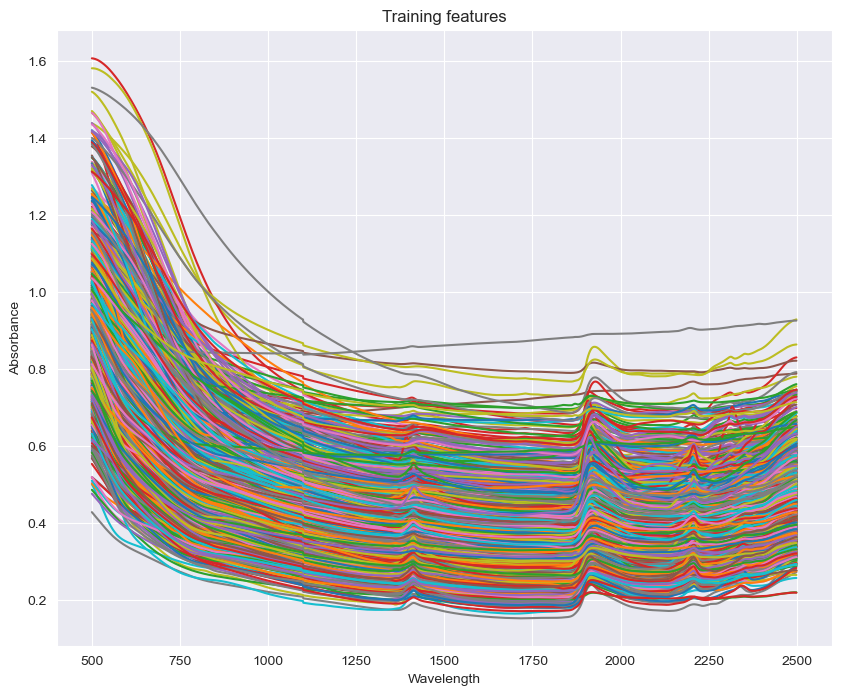

In [4]:
## Visualise features
for i in range(2000):
    x = np.arange(500, 2500)
    y = X_train[i]

    plt.plot(x, y)

plt.title("Training features")
plt.xlabel("Wavelength")
plt.ylabel("Absorbance")

plt.show()

From the figure above, it can be seen that the spectra are highly correlated with each other.  There is significant overlap across certain wavelengths, attributable to chromophores that exist in soils, such as sand, silt and clay.  It would be advantageous to reduce the dimensionality of the dataset using common statistical techniques, such as principal component analysis or partial least squares.

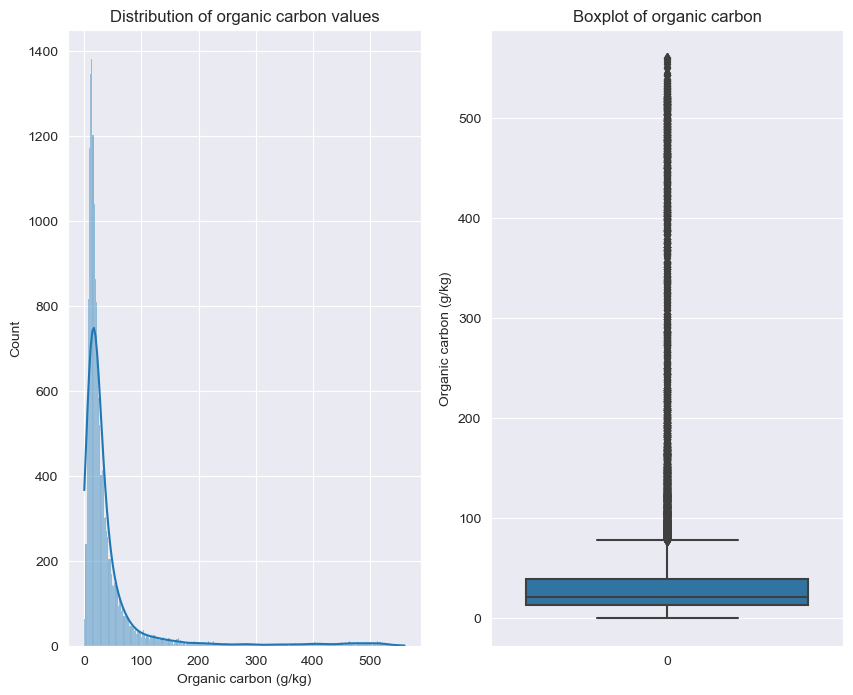

In [5]:
## Visualise target
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
## Label histogram
plt.title("Distribution of organic carbon values")
plt.xlabel("Organic carbon (g/kg)")

plt.subplot(1, 2, 2)
sns.boxplot(y_train)
## Label boxplot
plt.title("Boxplot of organic carbon")
plt.ylabel("Organic carbon (g/kg)")

plt.show()

It is clear from the figure above that the target variable is highly right-skewed, with the median value in the range of 20 g/kg of carbon.  From the boxplot it is also clear that there are numerous outliers present in the dataset.  These factors need to be taken into consideration when selecting for a loss function later on.  That will be discussed further in the next sections.

Below we scale both the training and testing datasets to smaller values more appropriate deep learning.  The data will undergo further preprocessing in another section, when dimensionality reduction techniques are discussed.

In [6]:
## Define standard scaler
scaler = StandardScaler()
## Scale training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2) Defining measure of success <a id="secondsection"></a>

Considering the regression task at hand and the fact that the training targets contain numerous outliers, mean absolute error (MAE) was chosen the success metric.  The first reason for this is that MAE is less sensitive to extreme outlier errors, which would make it more suitable for this regression task.  Secondly, MAE is much more interpretable than say mean squared error, as the values are expressed in the same units as the target variable.


#### Establishing a baseline

Below it was attempted to establish a simple baseline to beat for the regression task.  These values was used as a guide to determine the performance of the models that were trained in other sections.

#### a) Using median target value <a id="">median</a>

Considering that numerous outliers exist in the target variable, the median value was determined and applied as the prediction value for each soil sample.  The MAE was then calculated for this prediction vector. For a median value of 20.4 g/kg resulted in a MAE of 31.28 g/kg.  This value was taken as the absolute worst attainable metric, as it is in a sense equivalent to random guessing.

In [7]:
median_oc = np.median(y_train)

base_mae = mean_absolute_error(y_train, np.repeat(median_oc, len(y_train)))

print(f"""
Using only the median of {round(median_oc, 2)} g/kg
to estimate organic carbon, results in
a mean absolute error of {round(base_mae, 2)} g/kg.""")


Using only the median of 20.4 g/kg
to estimate organic carbon, results in
a mean absolute error of 31.28 g/kg.


#### b) Using Principal Component Regression <a id="pcr"></a>

Principal component regression (PCR) is a commonly utilised statistical technique for high dimensional datasets.  The feature set is projected onto linear components that describe the most variance observed in the feature set.  These linear components are simply linear combinations of the original feature set, which results in a lower dimensional feature space.  The first principal component describes the most variance, with the amount of variance decreasing for each successive component.

For PCR, the principal components are used to fit a linear regression model onto to predict the target variable.  An advantage of this technique, besides reducing dimensionality, is that is a useful approach to dealing with the multicollinearity that exists within this dataset.  A significant drawback of this approach is that it does not take the observed variance in the target variable into consideration, which may limit the predictive potential of this technique.

Below we perform repeated K-fold validation on 1 to 100 principal components to establish the minimum MAE attainable within that range of principal components.  This value will serve as additional information to establish a reliable baseline value with which to compare model performance.

Lowest MAE score for 100 principal components:  16.52


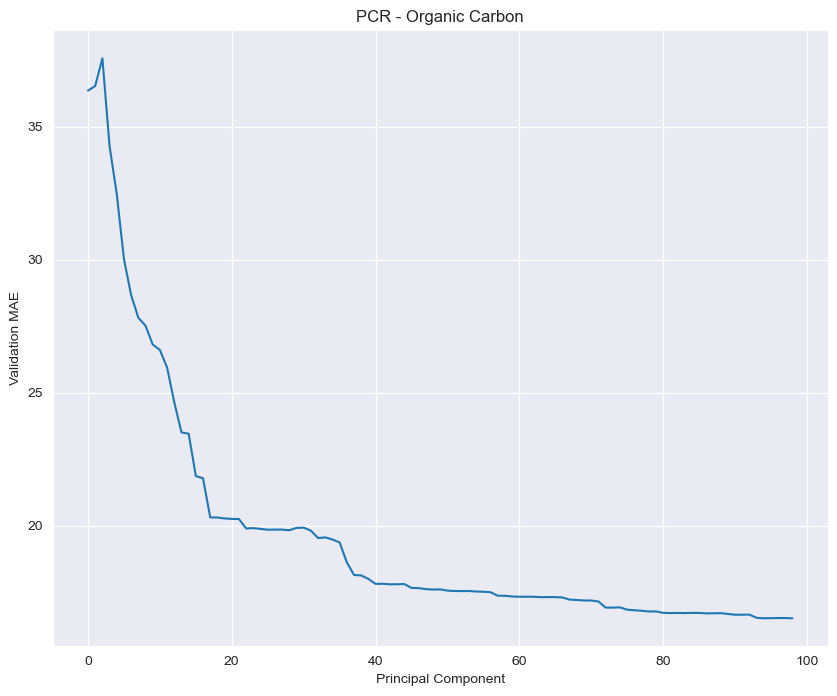

In [8]:
## Determine principal components
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_scaled)

## Define cross validation method
repeated_cv_pcr = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

## Define linear model
lm = LinearRegression()
mae_pcr = [] # To store validation results

## Calculate MAE using cross validation per component
for i in np.arange(1, 100):

    val_score_pcr = -1 * cross_val_score(estimator=lm,
                                         X=X_train_reduced[:,:i], y=y_train,
                                         cv=repeated_cv_pcr,
                                         scoring="neg_mean_absolute_error").mean()
    mae_pcr.append(val_score_pcr)

# Plot validation MAE against number of components
plt.plot(mae_pcr)
plt.xlabel("Principal Component")
plt.ylabel("Validation MAE")
plt.title("PCR - Organic Carbon")
print("Lowest MAE score for 100 principal components: ", np.round(np.min(mae_pcr), 2))

The lowest MAE attainable with 100 principal compenents was 16.52 g/kg.  This indicates that the dataset contains information to predict organic carbon, however this approach may not be the most optimal.  Additionally, since PCR does not take the target variable into consideration, it may be more appropriate to investigate the suitability of PLSR.

#### c) Using Partial Least Squares Regression <a id="plsr"></a>

The next attempt at establishing a baseline was to use partial least squares regression (PLSR).  This technique is the most widely accepted predictive approach in soil spectroscopy literature.  PLSR functions similarly to PCR, however this techniques relies on finding a number of latent variables that can explain the relationship between the feature space and the target variable.  These latent variables are similar to the principal components of PCR, and are as such only linear combinations of the original feature space.

These latent variables are then similarly fed to a linear regression model to fit a multivariate model to these latent variables.  An advantage of this technique is that the target variable is taken into account by the latent variables, and thus generally yields better predictive results compared to PCR.  Additionally, this technique is also very effective at dealing with multicollinearity and diminensionality reduction of the feature space.

Below we perform repeated K-fold validation on 1 to 100 latent variables to establish the minimum MAE attainable within that range of latent variables.  This value will serve as additional information to the prior baseline values obtained to establish a reliable baseline value with which to compare model performance.

Lowest MAE score for 100 components:  15.41


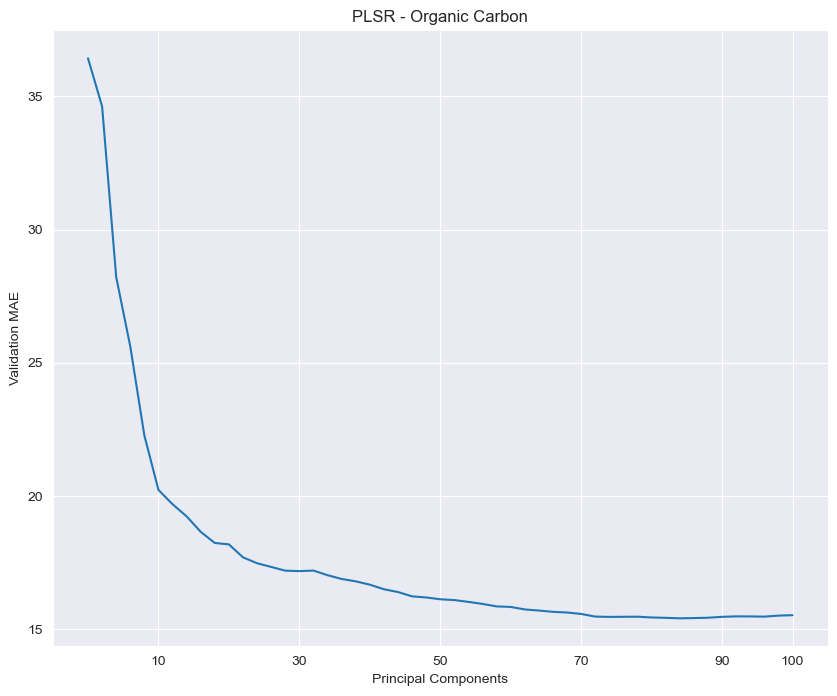

In [9]:
## Define cross validation method
repeated_cv_plsr = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

mae_plsr = [] # To store validation results

## Calculate MAE using cross validation per component
for i in np.arange(1, 102, 2):
    pls = PLSRegression(n_components=i)
    score = -1 * cross_val_score(estimator=pls,
                                 X=X_train_scaled, y=y_train,
                                 cv=repeated_cv_plsr,
                                 scoring='neg_mean_absolute_error').mean()
    mae_plsr.append(score)

# Plot validation MAE against number of components
plt.plot(mae_plsr)
plt.xlabel('Principal Components')
plt.xticks([5, 15, 25, 35, 45, 50],
           ["10", "30", "50", "70", "90", "100"])
plt.ylabel('Validation MAE')
plt.title('PLSR - Organic Carbon')
print("Lowest MAE score for 100 components: ", np.round(np.min(mae_plsr), 2))

PLSR performed only slightly better than PCR, with a lowest attainable MAE of 15.41 g/kg.  This was attainable with between 70 and 80 latent variables, less than what was required for PCR.  Considering PLSR performed slightly better than PCR, this technique will be used as a dimensionality reduction technique to preprocess that training data prior to modelling using a neural network.  However, 15.41 g/kg will be the baseline to beat in this project.

### 3) Evaluation protocol <a id="thirdsection"></a>

This section covers the evaluation protocol that was followed throughout this project.  The dataset at hand is neither significantly large nor very small.  Holdout validation would then be inappropriate in for such a dataset, yet repeated K-fold validation would be excessive and computationally demanding.  For these reasons, K-fold validation was selected as the evaluation protocol, with 5 folds being applied to the training dataset.

The training loss values and training MAE was averaged over the five folds into singular values.  The validation results for each fold was collected for each model evaluated, and analaysed accordingly.  Below, a set of functions are defined to automate much of the model building, compiling, training, and evaluation of each of the models.

Below, a function is defined to automate the model building procedure employed in this project.  The function is able to build general sequential neural networks, however also has the option to set regularisation or dropout as needed.

In [10]:
## Define function to automate model building
def build_model(num_units, num_layers, output_size=1, activation='relu', learning_rate=1e-3, loss="mean_squared_error",
                optimizer=tf.keras.optimizers.Adam, dropout=True, dropout_rate=0.2, regularization=False, reg_type="l2", reg_weight=0.002):
    model = tf.keras.Sequential()
    # Enable dropout
    if dropout:
        # Add hidden layers with dropout after every uneven numbered layer (e.g. 1, 3, 5 etc.):
        for i in range(num_layers):
            model.add(tf.keras.layers.Dense(units=num_units, activation=activation))
            if i % 2 != 0:
                model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    # Enable regularisation
    elif regularization:
        if reg_type == "l2":
            for i in range(num_layers):
                model.add(tf.keras.layers.Dense(units=num_units, activation=activation,
                                                kernel_regularizer=regularizers.l2(reg_weight)))
        elif reg_type == "l1":
            for i in range(num_layers):
                model.add(tf.keras.layers.Dense(units=num_units, activation=activation,
                                                kernel_regularizer=regularizers.l1(reg_weight)))
        elif reg_type == "l1_l2":
            for i in range(num_layers):
                model.add(tf.keras.layers.Dense(units=num_units, activation=activation,
                                                kernel_regularizer=regularizers.l1_l2(l1=reg_weight/2, l2=reg_weight/2)))
    # Build standard sequential model
    else:
        # Add hidden layers:
        for i in range(num_layers):
            model.add(tf.keras.layers.Dense(units=num_units, activation=activation))


    # Add output layer
    model.add(tf.keras.layers.Dense(units=output_size))

    # Compile the model
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss, metrics=['mae'])

    return model

Below a function was defined to run experimentation of various models.  It takes as input the training data and a set of parameters.  These parameters contain information of the number of units and hidden layers in the model, and are passed in tuple format.  The function further takes arguments such as the desired loss function, optimiser, learning rate, and other parameters suited for experimentation.

The results of each model evaluation is stored in dataframes that get returned at the end of the experimental run.  These dataframes were investigated after each successive experimentation, to derive information on the ideal model architecture for this project.

In [11]:
## Define function to automate experimentation on desired sequential models
def cross_validate_model(X, y, params_set, cv=5, n_epochs=500, batch_size=512, verbose=0, learning_rate=1e-3, loss="mean_squared_error", seed=42,
                         optimizer=tf.keras.optimizers.Adam, dropout=False, dropout_rate=0.2, regularization=False, reg_type="l2", reg_weight=0.002):
    # Check if features and target are of same size
    if len(X) == len(y):
        # Define empty dataframe to store validation results
        results_df = pd.DataFrame(columns=["epoch", "training_loss", "validation_loss", "units", "layers", "model"])
        # Define empty dataframe to store validation scores
        val_scores_df = pd.DataFrame(columns=["model", "val_error", "fold"])

        for model_no in range(len(params_set)):
            # Collect model parameters
            params = params_set[model_no]
            print(f"Processing model {model_no+1} of {len(params_set)}")
            # Define empty dataframe to store results of each fold
            fold_df = pd.DataFrame(columns=["epoch", "training_loss", "validation_loss", "units", "layers", "model"])
            # Split data into cv number of folds
            k_folds = KFold(n_splits=cv, shuffle=True, random_state=seed)
            fold = 1 # Counter variable
            # Initiate cross validation
            for train_index, val_index in k_folds.split(X):
                print(f"Fold {fold} of {cv}")
                # Create training and validation datasets
                x_train, x_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                # Create model
                model = build_model(num_units=params[0],
                                    num_layers=params[1],
                                    learning_rate=learning_rate,
                                    dropout=dropout,
                                    dropout_rate=dropout_rate,
                                    regularization=regularization,
                                    reg_type=reg_type,
                                    reg_weight=reg_weight,
                                    loss=loss,
                                    optimizer=optimizer)
                # Collect training history for current fold
                history = model.fit(x_train, y_train,
                                    epochs=n_epochs,
                                    batch_size=batch_size,
                                    validation_data=(x_val, y_val),
                                    verbose=verbose)
                # Collect validation score for current fold
                _, validation_score = model.evaluate(x_val, y_val, batch_size=batch_size)
                # Define dataframe with validation results
                validation_df = pd.DataFrame.from_dict({"epoch": np.arange(1, n_epochs+1),
                                                        "training_loss": history.history["loss"],
                                                        "validation_loss": history.history["val_loss"],
                                                        "units": np.repeat(params[0], n_epochs),
                                                        "layers": np.repeat(params[1], n_epochs),
                                                        "model": np.repeat(model_no+1, n_epochs)})
                # Create dataframe to store validation scores for each fold
                val_scores = pd.DataFrame.from_dict({"model": f"Model {model_no+1}",
                                                     "val_error": [validation_score],
                                                     "fold": [fold]})
                # Append training and validation loss to dataframe
                if fold_df.shape[0] != 0:
                    fold_df["training_loss"] += validation_df["training_loss"]
                    fold_df["validation_loss"] += validation_df["validation_loss"]
                else:
                    fold_df = pd.concat([fold_df, validation_df])
                # Append current fold validation dataframe to final validation dataframe
                val_scores_df = pd.concat([val_scores_df, val_scores])
                # Increment counter variable
                fold += 1
            # Collect mean training and validation loss for current model
            fold_df["training_loss"] = fold_df["training_loss"].divide(cv)
            fold_df["validation_loss"] = fold_df["validation_loss"].divide(cv)
            # Append validation run results to final results dataframe
            results_df = pd.concat([results_df, fold_df])
        # Return final experimental results
        return results_df, val_scores_df
    else:
        print("Feature and target length not equal.")


Below a function was defined to visualise the experimental results.  The function takes as input the training and validation losses for the experiment, for each respective model.  This data is the visualised using a facet grid where columns designate the layers parameter and rows the number of units parameter.

In [12]:
## Define function to visualise training and validation losses
def visualise_experimental_results(experimental_results, by_col="layers", by_row="units", title="Some title"):
    # Create facet grid object
    g = sns.FacetGrid(experimental_results, col=by_col, row=by_row, sharey=False, margin_titles=True)
    # Map training loss to facet grid object
    g.map(plt.plot, "epoch", "training_loss", color="red", linestyle="dashed", label="Training", alpha=0.8)
    # Map validation loss to facet grid object
    g.map(plt.plot, "epoch", "validation_loss", color="yellow", label="Validation", alpha=0.5)
    # Label facet grid object
    g.set_axis_labels("Epoch", "Loss") # axis labels
    g.add_legend(title="Loss") # title
    # Adjust height of title
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(title)

The final function that was used throughout this project is one to summarise the validation results for each model during experimentation.  The function takes as input the validation scores for each model per fold and returns an ordered table of the mean MAE across all folds and the associated standard deviation.  The function visualises and compares all models' validation scores by using boxplot diagrams.

In [13]:
## Define function to summarise and visualise validation results
def summarise_validation_results(validation_results, top_n=5):

    print(f"Top {top_n} models based on mean validation error:\n")
    # Create grouped, sorted dataframe with mean validation error and associated standard error
    x = validation_results.groupby("model").aggregate({"val_error": ["mean", "std"]}).sort_values([('val_error', 'mean'), ('val_error', 'std')]).head(top_n)
    print(x, "\n\n")
    # Create boxplot object visualising validation scores
    graph = sns.boxplot(data=validation_results, x="val_error", y="model")
    # Label boxplot diagram
    graph.set(title="Cross validation results", xlabel="Validation Mean Absolute Error", ylabel="")

    plt.show()

### 4) Data preparation <a id="fourthsection"></a>

In the previous section when defining a baseline performance measure, PLSR outperformed PCR in predictive modelling.  Since PLSR takes the target variable into consideration when assembling the latent variables, it results in a strong predictive potential.  PLS was chosen as the statistical technique to reduce the dimensionality of the training features, which was used as input for the sequential neural networks evaluated in the study.

Only 50 latent variables were selected, as a larger number of latent variables did not show significant increases in predictive ability.  Both the training and testing feature datasets were transformed into these latent variables, and the final values were scaled once again within a range of [-1:1].

In [14]:
## Define number of latent variables
pls_transform = PLSRegression(n_components=50)
## Transform training data
pls_fit_train = pls_transform.fit_transform(X_train_scaled, y=y_train)
## Transform testing data
pls_fit_test = pls_transform.transform(X_test_scaled, y_test)
## Extract latent variables
X_train_pls = pls_fit_train[0]
X_test_pls = pls_fit_test[0]

## Scale latent variables
pls_scaler = StandardScaler()
X_train_pls_scaled = pls_scaler.fit_transform(X_train_pls)
X_test_pls_scaled = pls_scaler.transform(X_test_pls)

### 5) Model selection <a id="fifthsection"></a>

The model selection procedure was set up to search over a two-dimensional hyperparameter space.  The parameters in question were the number of units in the model, and the number of layers.  There were three values of each parameter selected, for which unique combinations were made.  These parameter combinations resulted in a total of 9 different models being developed and experimented on.

Considering that the dataset contains numerous outliers, an appropriate loss function had to be selected.  It was decided to go against root mean squared error (RMSE), as this loss function would be too sensitive to outliers and result in large errors on the outlier values.  Similarly, MAE was also decided against, as the number of outliers are significant, which could still result in significant loss values.  Additionally, MAE is not differentiable, which could result in the model struggling to train properly.  For these reasons, it was decided to utilise the Huber loss function (Huber, 1992).  This loss function is less sensitive to outliers than the RMSE loss function, and is defined as follows (Abadi, et al., 2015):

$$L_{\delta} = \begin{cases}
        \frac{1}{2}(y - \hat{y})^{2} & if \left | (y - \hat{y})  \right | < \delta\\
        \delta ((y - \hat{y}) - \frac1 2 \delta) & otherwise
    \end{cases} $$

where $\delta$ is a hyperparameter that determines the point at which the loss function transitions from being quadratic to linear.  The benefits of this loss function compared to RMSE or MAE is that the Huber loss is less sensitive to large errors (thus outliers) and is continuously differentiable.

In addition to the structural hyperparameters that were investigated, three optimisers were also investigated.  These include the popular RMSprop, Adagrad, and Adam optimisers.  Although RMSprop and Adagrad are quite similar, it was worth experimenting between the two to find which was most suitable.

In [15]:
## Define experimental parameters
experimental_parameters = [
    [16, 64, 256], # Number of units
    [2, 5, 8] # Number of layers
]

parameter_set = list(itertools.product(*experimental_parameters))

##### 1.1) With RMSprop optimiser

Experimentation with the RMSprop optimiser on each of the neural network architectures were performed below.  It was expected that the RMSprop optimiser would be able to result in faster convergence, thus the standard learning rate of 0.001 was selected in this case.

In [ ]:
results_rmsprop, val_scores_rmsprop = cross_validate_model(X_train_pls_scaled, y_train, cv=5, params_set=parameter_set, n_epochs=500, learning_rate=1e-3,
                                                           batch_size=2048, loss="huber_loss", optimizer=tf.keras.optimizers.RMSprop, verbose=1)

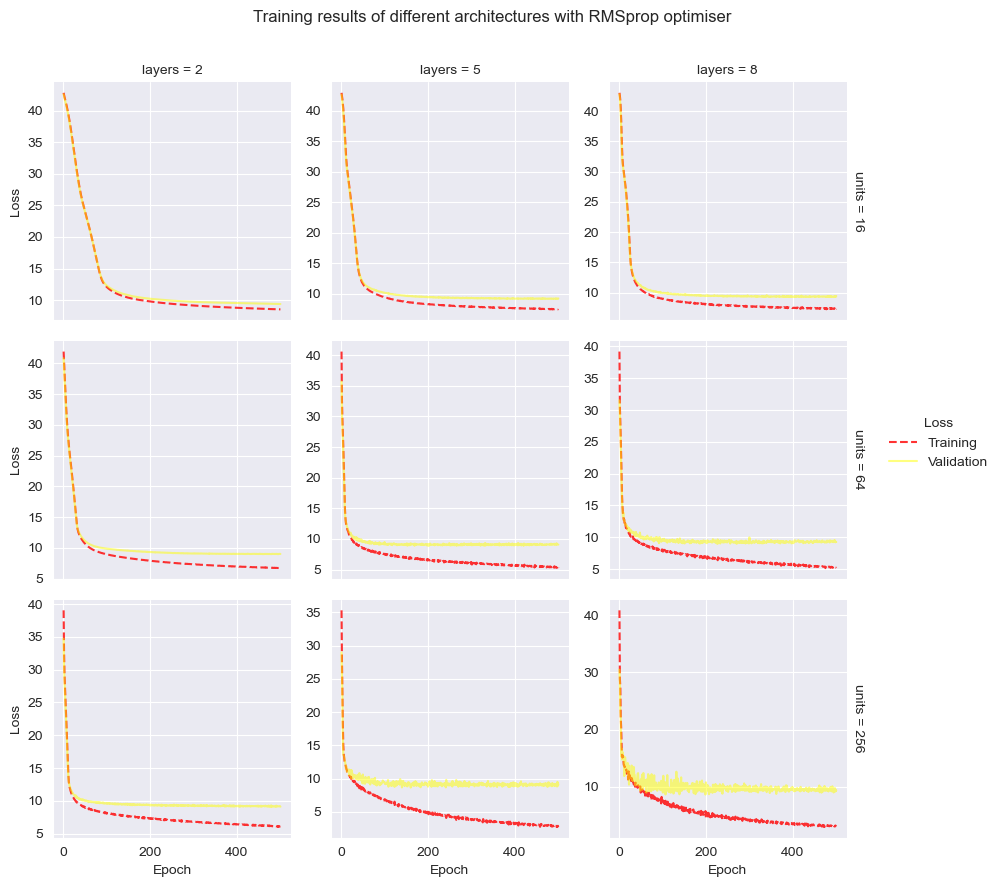

In [17]:
visualise_experimental_results(results_rmsprop, title="Training results of different architectures with RMSprop optimiser")

From the figure above, it could be seen that the training and validation losses took longer to diverge for smaller models compared to the larger models.  The smaller models also showed much less overfitting compared to the larger ones, which is to be expected.  It is clear from the above that larger models are required on this dataset to ensure enough representative capacity.  However, the largest model's validation loss was very choppy, indicating that the model significantly started overfitting at a much earlier epoch.  Interestingly, the validation loss in most cases plateaued, indicating that perhaps this sequential architecture is not appropriate, or that the model became stuck in a local minima.

Overall, model 4 (2 layers, 64 units) performed best out of the nine models.  It achieved the lowest mean validation error over all folds, and also had the lowest standard deviation.  It was therefore the quite stable out compared to the other nine models.  Interestingly, model 7 (2 layers, 256 units) performed similarly, with only a slightly larger mean validation error.  It is evident from the results that adding more layers in generally resulted in larger validation errors which tended to vary more.  The smaller models (with 16 units) performed the worst on average, due to their lack of representational power.  With this combination of optimiser and learning rate, the intermediate models (with 64 units) performed best on average, with the larger networks following close by.

Top 5 models based on mean validation error:

        val_error          
             mean       std
model                      
Model 4  9.482550  0.126839
Model 5  9.556357  0.245562
Model 8  9.604338  0.321450
Model 7  9.611634  0.124231
Model 6  9.724100  0.283601 




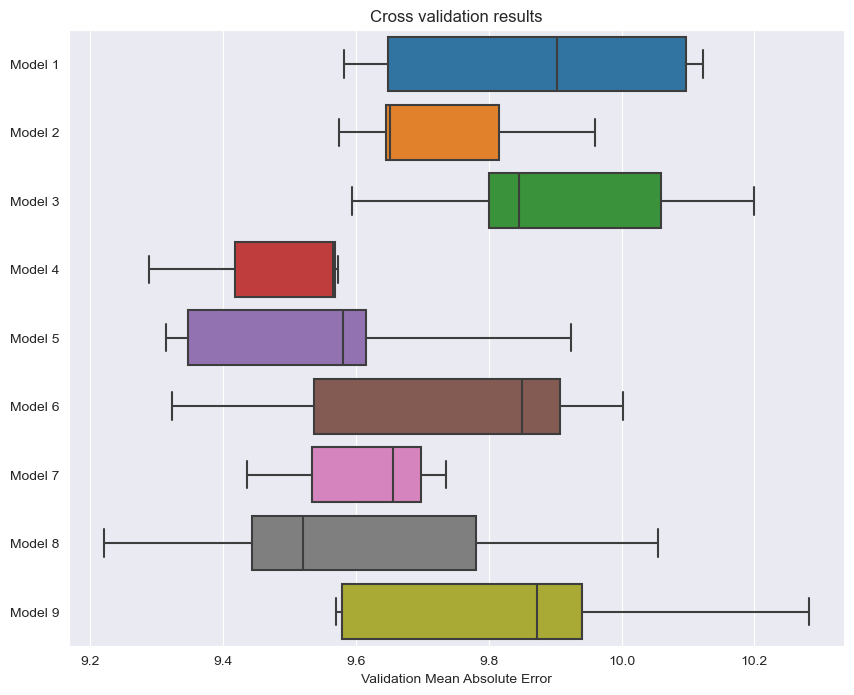

In [18]:
summarise_validation_results(val_scores_rmsprop)

##### 1.2) With Adagrad optimiser

The experiment was similarly carried out with an investigation into using the Adagrad optimiser.  Considering that the Adagrad optimiser tends to be slower to converge than the RMSprop optimiser, it was decided to utilise a larger learning rate of 0.1.

In [ ]:
results_adagrad, val_scores_adagrad = cross_validate_model(X_train_pls_scaled, y_train, cv=5, params_set=parameter_set, n_epochs=300, learning_rate=0.1,
                                                           batch_size=2048, loss="huber_loss", optimizer=tf.keras.optimizers.Adagrad)

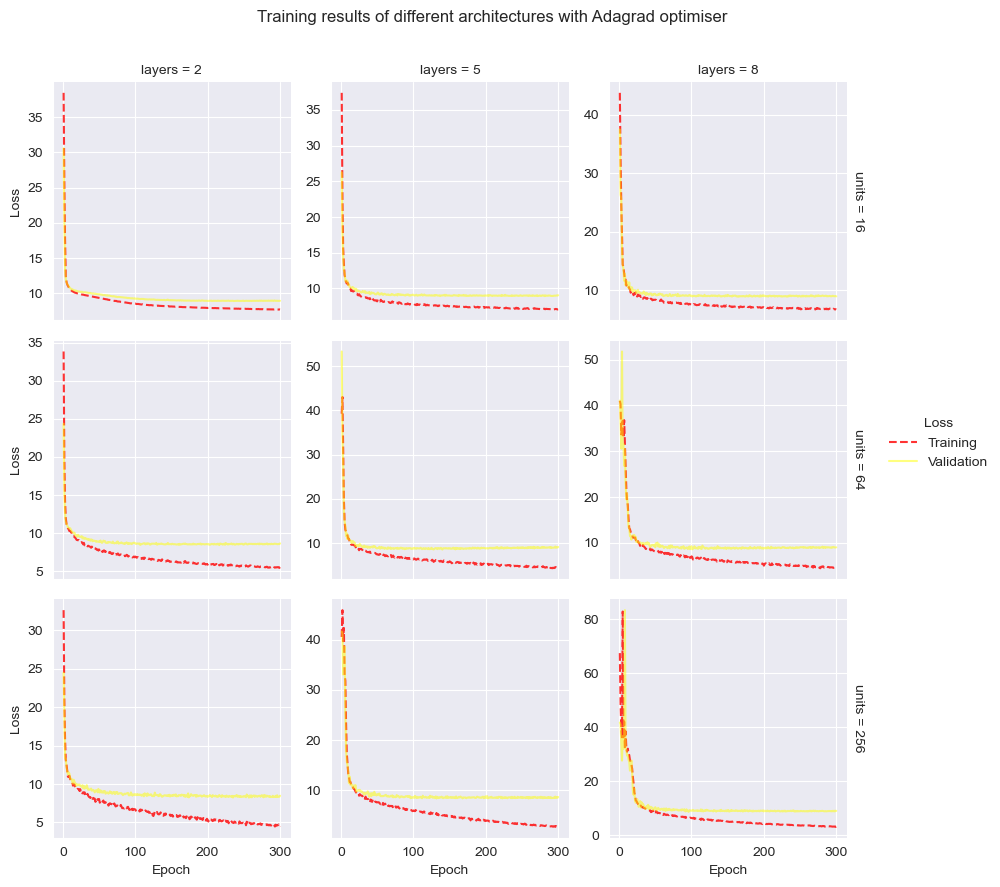

In [20]:
visualise_experimental_results(results_adagrad, title="Training results of different architectures with Adagrad optimiser")

The results obtained above were similar to the experiment that utilised the RMSprop optimiser.  Once again, the smaller models did not show significant overfitting which is attributable to their low representational capacity.  In general, the models with the Adagrad optimiser performed slightly better on average than their counterparts that utilised RMSprop.  The reason for this better performance may be attributed to less noise in the dataset, to which Adagrad is more suited.

The results below indicate that model 7 (2 layers, 256 units) performed the best, cloesly followed by model 4 (2 layers, 64 units).  These two models also showed low standard deviations for the mean validation errors across all folds.  Interestingly, model 8 (5 layers, 256 units) also performed well and was quite stable.  It seems to emerge that models with more units are better at the regression task at hand, perhaps due to their greater ability to represent more complex patterns in the data.

Top 5 models based on mean validation error:

        val_error          
             mean       std
model                      
Model 7  8.956364  0.224189
Model 4  9.132812  0.296001
Model 8  9.159602  0.164379
Model 1  9.430290  0.252246
Model 9  9.448491  0.270074 




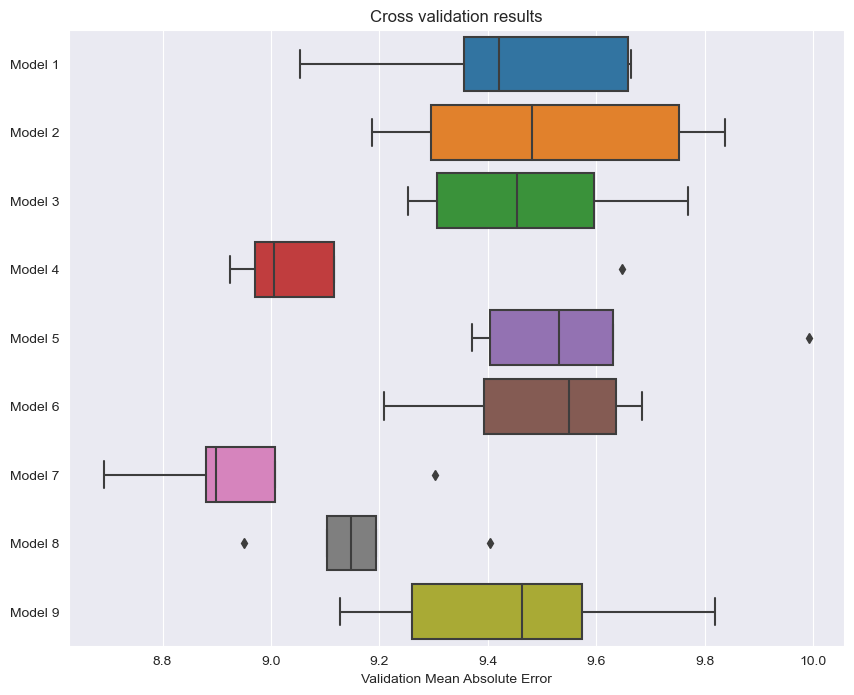

In [21]:
summarise_validation_results(val_scores_adagrad)

##### 1.3) With Adam optimiser

The final optimiser that was experimented with was the Adam optimiser.  The reason for this choice is due to its general popularity and advantages over optimisers such as RMSprop.  For this final experiment, a learning rate of 0.02 was selected.

In [ ]:
results_adam, val_scores_adam = cross_validate_model(X_train_pls_scaled, y_train, cv=5, params_set=parameter_set, n_epochs=300, learning_rate=1e-2,
                                                     batch_size=2048, loss="huber_loss", optimizer=tf.keras.optimizers.Adam)

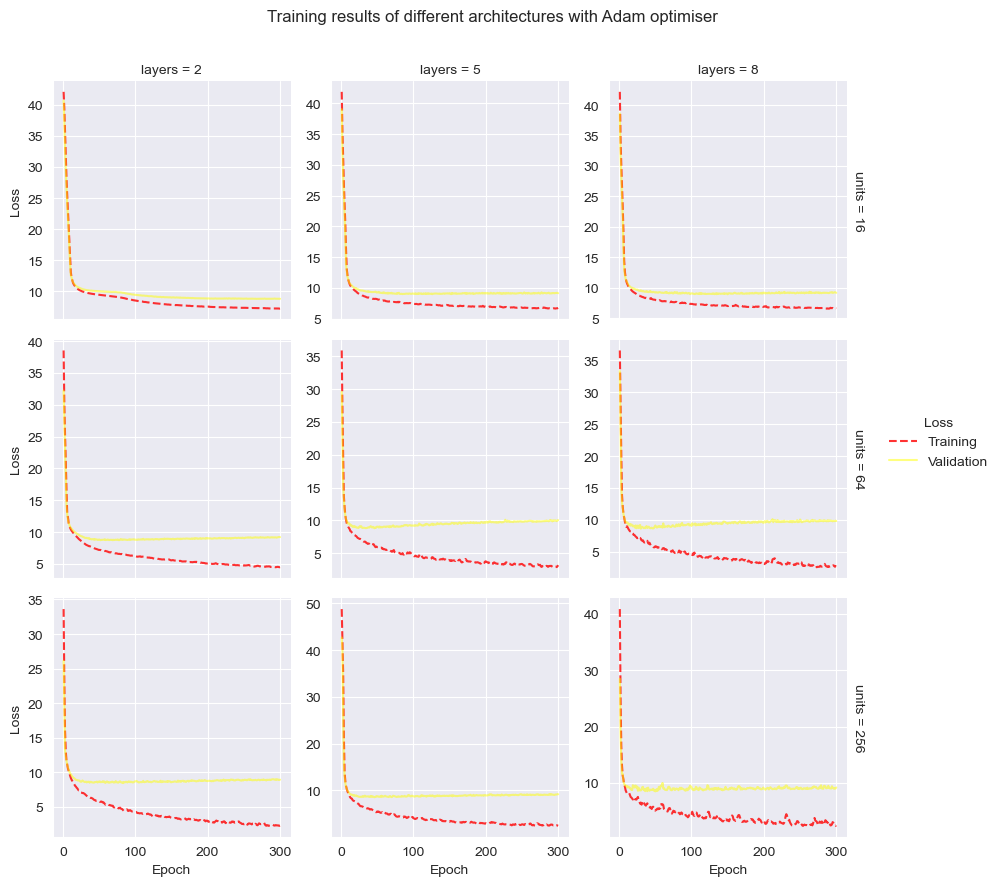

In [23]:
visualise_experimental_results(results_adam, title="Training results of different architectures with Adam optimiser")

The results above indicate a significant difference in performance than the previous optimisers used.  The most notable difference is how quickly the model was able to converge, even on very small models.  Although overfitting was not very pronounced on the smaller models, it became significant on the larger models with 64 units and more.  Additionally, the overfitting was more pronounced than in the previous two cases.  It is clear that Adam is much more effective at escaping from local minima and result in models with greater representational power.

Below it can be seen that the validation results are significantly different from the previous two cases.  The most noteable observation is that of the smallest model (Model 1) performing best on average.  This may be attributed to the other models overfitting more significantly within the given epochs.  It would therefore be beneficial to stop training much earlier when using the Adam optimiser.  Once again, model 7 (2 layers, 256 units) stood out as a strong performer.  It is becomes evident that this model has the best learning capacity for the problem at hand, and was selected as the final architecture going forward.

Top 5 models based on mean validation error:

        val_error          
             mean       std
model                      
Model 1  9.291510  0.157662
Model 7  9.397570  0.244210
Model 8  9.608912  0.242112
Model 2  9.620192  0.085618
Model 9  9.638986  0.373288 




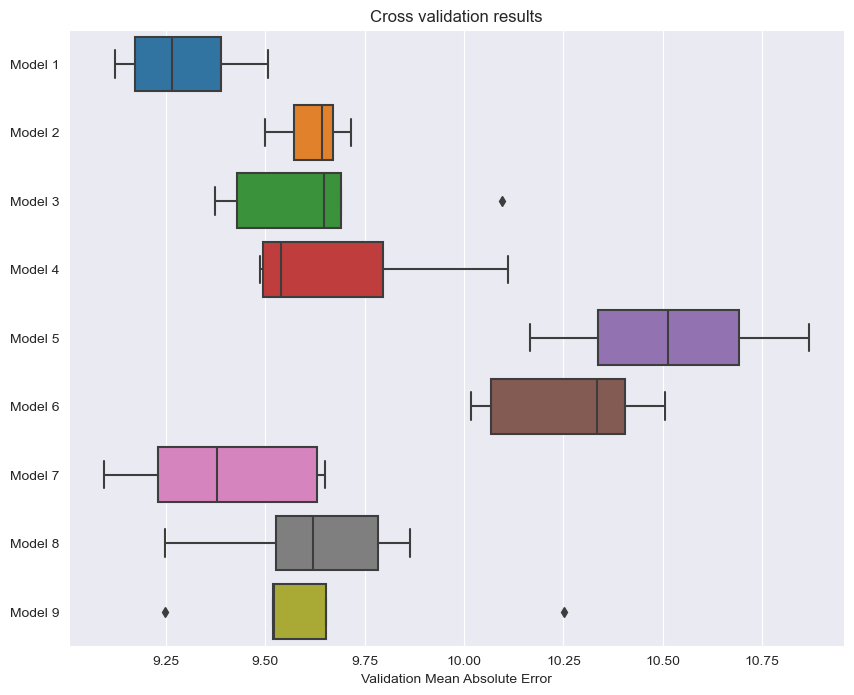

In [24]:
summarise_validation_results(val_scores_adam)

### 6) Model regularisation <a id="sixthsection"></a>

The final experimental run was to evaluate the effect of regularisation on model performance.  The first part of this section evaluated the different approaches to loss regularisation (L1, L2, L1 and L2).  Additionally, three regularisation weights were evaluated in conjunction with the regularisation approaches.  The model architecture that was settled on for this section of the project was a model with 2 layers and 256 units.  The model also utilised the Adagrad optimiser with a learning rate of 0.1 and the Huber loss function.

In [25]:
## Set model parameters
new_parameter_set = [(256, 2)]
## Define regularisation search space
reg_space = list(itertools.product(*[[0.2, 0.02, 0.002], ["l1", "l2", "l1_l2"]]))
reg_space

[(0.2, 'l1'),
 (0.2, 'l2'),
 (0.2, 'l1_l2'),
 (0.02, 'l1'),
 (0.02, 'l2'),
 (0.02, 'l1_l2'),
 (0.002, 'l1'),
 (0.002, 'l2'),
 (0.002, 'l1_l2')]

#### a) Regularisation

Below an experiment was run to evaluate the effect of regularisation on model performance.  The same cross validation function was used to that used in previous experiments.  The only change to the approach was the use of a for loop to feed the different types of regularisation and their associated weight weights to said function.

In [ ]:
## Define empty dataframes to store results
results_regularisation, val_scores_regularisation = pd.DataFrame(columns=["epoch", "training_loss", "validation_loss", "units", "layers", "model", "regulariser", "weight"]), \
    pd.DataFrame(columns=["model", "val_error", "fold"])

for count, reg_set in enumerate(reg_space):
    results_df, val_df = cross_validate_model(X_train_pls_scaled, y_train, cv=5, params_set=new_parameter_set, n_epochs=300, learning_rate=0.1,
                                              batch_size=2048, loss="huber_loss", optimizer=tf.keras.optimizers.Adagrad,
                                              regularization=True, reg_type=reg_set[1], reg_weight=reg_set[0])

    results_df["model"] = np.repeat(f"Model {count+1}", len(results_df))
    results_df["regulariser"] = np.repeat(reg_set[1], len(results_df))
    results_df["weight"] = np.repeat(reg_set[0], len(results_df))

    val_df["model"] = np.repeat(f"Model {count+1}", len(val_df))

    results_regularisation = pd.concat([results_regularisation, results_df])
    val_scores_regularisation = pd.concat([val_scores_regularisation, val_df])

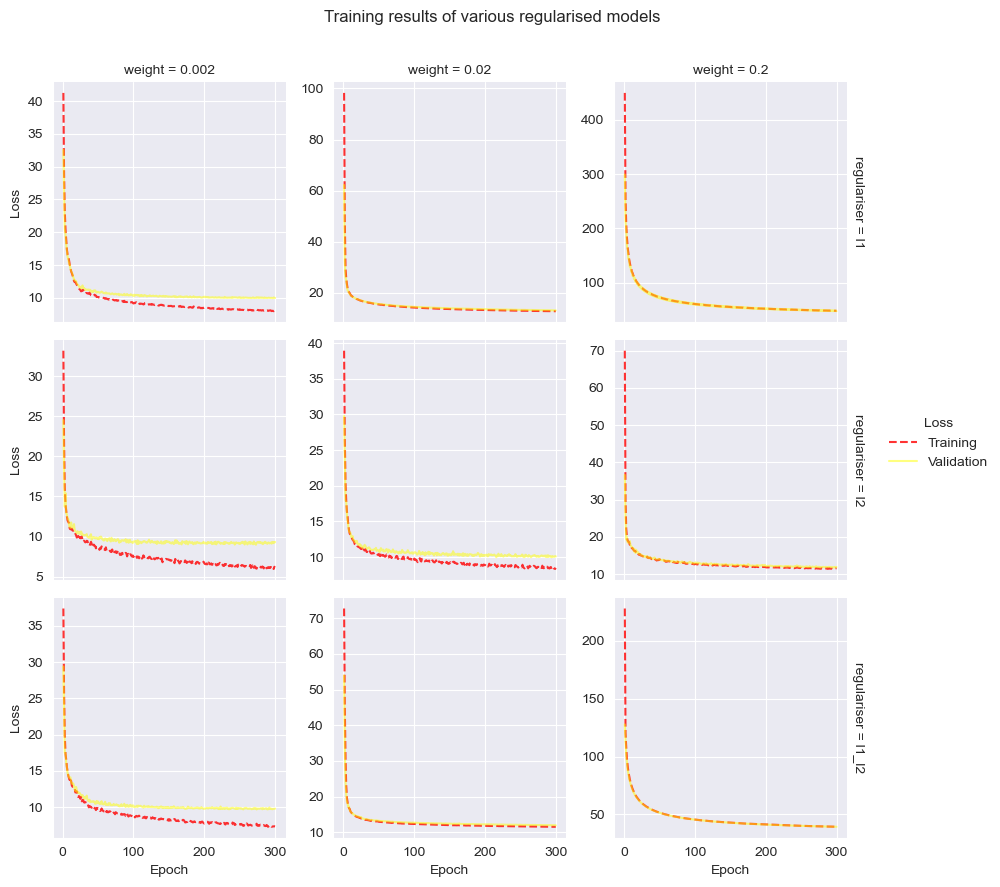

In [27]:
visualise_experimental_results(results_regularisation, by_row="regulariser", by_col="weight", title="Training results of various regularised models")

The experimental results illustrate the effect of regularisation on a models ability to overfit.  In the case of the highest regularisation weight, overfitting was non-existent.  The model parameters were penalised too harshly, resulting in models that had very little capacity to represent complex patterns.  The results were similar in the case of a regularisation weight of 0.02, with the expection of L2 regularisation.  In this case the model still showed some representational power, due to a less sparse model.  Finally, a small regularisation weight resulted in a model that retained its representational power, but not to the same extent as an unregularised model.  It could be seen that the model overfit less and at a slightly later epoch.

It was concluded from the experimental results that either L1 and L2 regularisation or only L2 regularisation should be preferred on this model architecture.  L1 and L2 regularisation resulted in a model that had the lowest mean validation error and the smallest standard deviation.  L1 regularisation fared worse in almost all cases, which can be attributed to this process resulting in a sparse model with poor representational power.  It appears that combined L1 and L2 regularisation with a small regularisation penalty of 0.002 is ideal for this model architecture.

Top 5 models based on mean validation error:

         val_error          
              mean       std
model                       
Model 9   8.830637  0.133522
Model 8   8.916301  0.253675
Model 7   9.012841  0.197495
Model 5   9.049042  0.391194
Model 2  10.113050  0.203319 




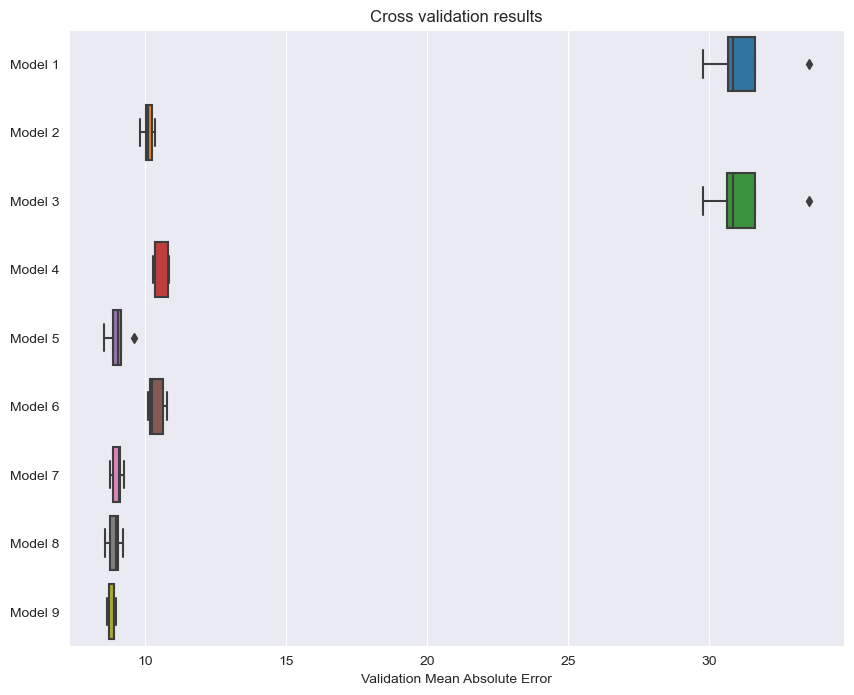

In [28]:
summarise_validation_results(val_scores_regularisation)

#### b) Dropout

The final experiment of the project evaluated the effect of dropout on model performance.  For this experiment, four values were selected for dropout rate, going from very low to high.  The experimental procedure remained the same as in previous sections, except for utilising a for loop to iterate through the various dropout rates.

In [ ]:
## Define empty dataframes to store results
results_dropout, val_scores_dropout = pd.DataFrame(columns=["epoch", "training_loss", "validation_loss", "units", "layers", "model", "rate"]), \
    pd.DataFrame(columns=["model", "val_error", "fold"])

for count, rate in enumerate([0.1, 0.3, 0.5, 0.7]):
    results_df, val_df = cross_validate_model(X_train_pls_scaled, y_train, cv=5, params_set=new_parameter_set, n_epochs=300, learning_rate=0.1,
                                              batch_size=2048, loss="huber_loss", optimizer=tf.keras.optimizers.Adagrad,
                                              dropout=True, dropout_rate=rate)

    results_df["model"] = np.repeat(f"Model {count+1}", len(results_df))
    results_df["rate"] = np.repeat(rate, len(results_df))

    val_df["model"] = np.repeat(f"Model {count+1}", len(val_df))

    results_dropout = pd.concat([results_dropout, results_df])
    val_scores_dropout = pd.concat([val_scores_dropout, val_df])

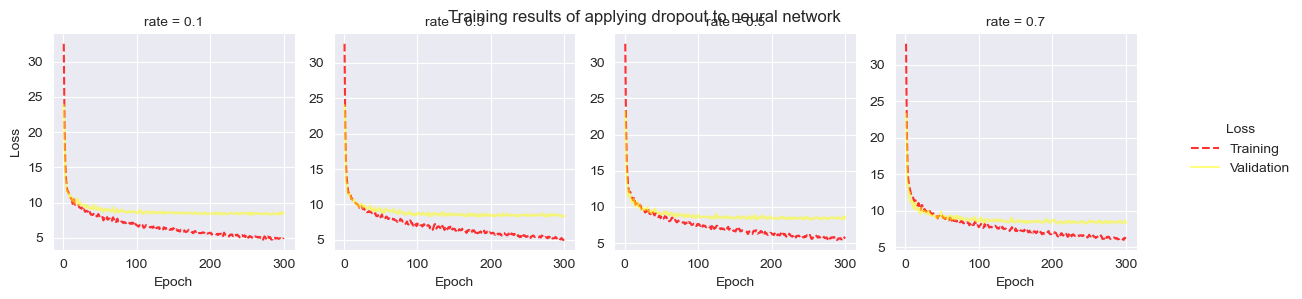

In [30]:
visualise_experimental_results(results_dropout, by_col="rate", by_row=None, title="Training results of applying dropout to neural network")

The results of the experiment showed that dropout did not have as pronounced of an effect on model overfitting as in the case of regularisation.  This may be attributed to the model being quite small, with dropout being more appropriate for larger, deeper models.  Nevertheless, the validation results showed that regularisation resulted in much lower average validation errors with very small standard deviations.  In this case however, it may be most appropriate to regularise the model parameters using combined L1 and L2 regularisation.

Top 5 models based on mean validation error:

        val_error          
             mean       std
model                      
Model 4  8.754688  0.122025
Model 2  8.846663  0.138589
Model 3  8.858648  0.103528
Model 1  8.999915  0.303886 




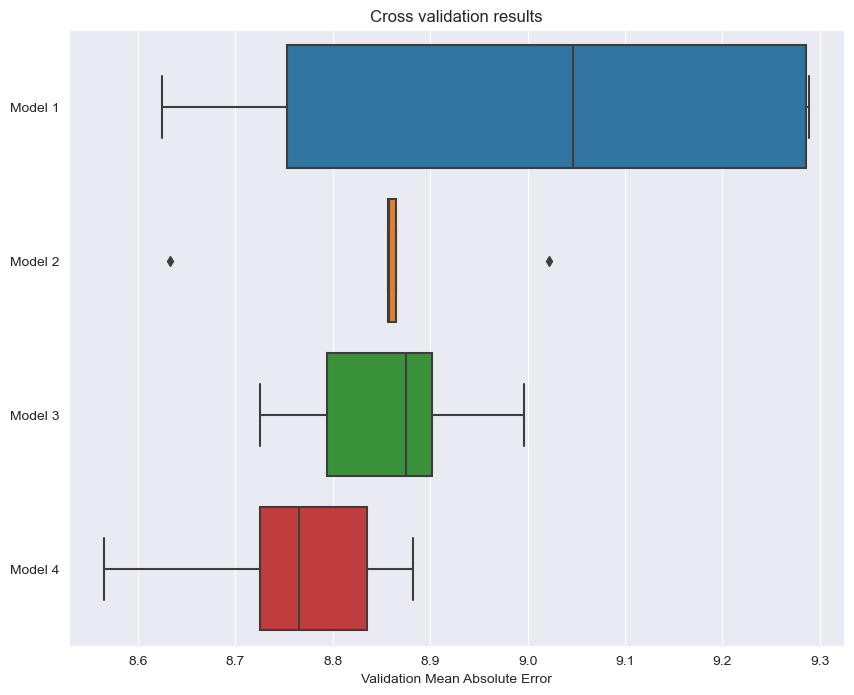

In [31]:
summarise_validation_results(validation_results=val_scores_dropout)

## Final model evaluation <a id="finalmodel"></a>

The final model was built by utilising 2 layers with 256 units each.  A learning rate of 0.1 was selected, with Adagrad optimising the Huber loss function.  Combined L1 and L2 regularisation was implemented with a regularisation weight of 0.002.  The final model was trained on all training data and evaluated on the test dataset.

In [ ]:
final_model = build_model(num_units=256, num_layers=2, learning_rate=0.1, optimizer=tf.keras.optimizers.Adagrad,
                          loss="huber_loss", regularization=True, reg_weight=0.002, reg_type="l1_l2")

training_history = final_model.fit(X_train_pls_scaled, y_train, epochs=50, batch_size=2048)
test_loss, test_mae = final_model.evaluate(X_test_pls_scaled, y_test)

In [39]:
print(f"""
Test loss for final model: {round(test_loss, 2)}
Test MAE for final model: {round(test_mae, 2)}""")


Test loss for final model: 8.97
Test MAE for final model: 9.45


## Conclusion <a id="conclusion"></a>

The final model performed much better than the established PLSR method that has been utilised in soil spectroscopy literature.  The final model achieved a MAE of 9.45 g/kg, which is quite acceptable in this case.  However, an average difference of that magnitude can have significant implications on the inference of soil quality potential and consequent fertiliser applications.  It would therefor be desirable to develop a model with greater accuracy.

Considering that spectroscopic data is a kind of sequential data, it becomes apparent that a simple sequential neural network may not be the appropriate architecture the leverage in this case.  In fact, Padarian, et al. (2019) and Lei and Sun (2022) showed that convolutional neural networks and transformer networks are much more appropriate.

Limitations of this study should be highlighted nevertheless.  The study did not evaluate a range of learning rates for each of the optimisers, which may have resulted in a more ideal configuration being missed.  Additionally, the selection of layers and units were crude and coarse, which may have resulted in a less than optimal architecture being selected.  Nevertheless, more advanced deep learning architectures need be investigated on this dataset in the future.

## References <a id="references"></a>

Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., Corrado, G.S., Davis, A., Dean, J., Devin, M., Ghemawat, S., Goodfellow, I., Harp, A., Irving, G., Isard, M., Jozefowicz, R., Jia, Y.,
Kaiser, L., Kudlur, M., Levenberg, J., Mané, D., Schuster, M., Monga, R., Moore, S., Murray, D., Olah, C., Shlens, J., Steiner, B., Sutskever, I., Talwar, K., Tucker, P., Vanhoucke, V., Vasudevan, V., Viégas, F., Vinyals, O., Warden, P., Wattenberg, M., Wicke, M., Yu, Y., and Zheng, X. TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from tensorflow.org.

Grunwald, S., Thompson, J. & Boettinger, J., 2011. Digital Soil Mapping and Modeling at Continental Scales: Finding Solutions for Global Issues. Soil Science Society of America Journal, Volume 75, pp. 1201-1213.

Lei, T. & Sun, D. W., 2022. Achieving joint calibration of soil Vis-NIR spectra across instruments, soil types and properties by an attention-based spectra encoding-spectra/property decoding architecture. Geoderma, Volume 405, doi:10.1016/j.geoderma.2021.115449.

Nocita, M. et al., 2015. Soil Spectroscopy: An Alternative to Wet Chemistry for Soil Monitoring. Advances in Agronomy, Volume 132, doi:10.1016/bs.agron.2015.02.002.

Orgiazzi, A., Ballabio, C., Panagos, P., Jones, A., Fernández-Ugalde, O. 2018. LUCAS Soil, the largest expandable soil dataset for Europe: A review. European Journal of Soil Science, 69(1): 140-153, DOI: 10.1111/ejss.12499

Padarian, J., Minasny, B. & McBratney, A. B., 2019. Using deep learning to predict soil properties from regional spectral data. Geoderma Regional, Volume 16, doi:10.1016/j.geodrs.2018.e00198.

Ramirez-Lopez, L. et al., 2013. The spectrum-based learner: A new local approach for modeling soil vis-NIR spectra of complex datasets. Geoderma, Volume 195-196, pp. 268-279.
Ren, J., Zhao, Y. & Yu, K., 2022. LIBS in agriculture: A review focusing on revealing nutritional and toxic elements in soil, water, and crops. Computers and Electronics in Agriculture, Volume 197, doi:10.1016/j.compag.2022.106986.

Viscarra Rossel, R. A. & McBratney, A. B., 1998. Soil chemical analytical accuracy and costs: implications from Precision Agriculture. Australian Journal of Experimental Agriculture, Volume 38, pp. 765 - 775.

Xu, S., Zhao, Y., Wang, M. & Shi, X., 2018. Comparison of multivariate methods for estimating selected soil properties from intact soil cores of paddy fields by Vis-NIR spectroscopy. Geoderma, Volume 310, pp. 29-43.

van Leeuwen, C. C. E., Mulder, V. L., Batjes, N. H. & Heuvelink, G. B. M., 2022. Statistical modelling of measurement error in wet chemistry soil data. European Journal of Soil Science, 73(1), doi:10.1111/ejss.13137.